Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Install useful libraries

In [2]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

Defaulting to user installation because normal site-packages is not writeable
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.1.113 requires chromadb<0.5.0,>=0.4.24, but you have chromadb 0.4.17 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 96.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [3]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## My Solution

In [4]:
from openai import OpenAI

# Create OpenAI client
client = OpenAI()

In [5]:
# Replace NaN values
reviews["Review Text"] = reviews["Review Text"].fillna("No Review")

# Get reviews as a list
review_text = [review[0] for review in reviews[["Review Text"]].values.tolist()]

In [6]:
# Clear the review texts - for the special characters because it gets error in embedding creation part
def clean_text_for_embeddings(text):
    text = text.replace('\\', '\\\\')
    
    text = text.replace('"', '\\"')
    
    text = text.replace("'", "\\'")
    
    text = text.replace('\n', ' ').replace('\r', ' ')
    
    return text


reviews_texts = [clean_text_for_embeddings(review) for review in review_text]

In [7]:
# Create embedding function
def create_embeddings(texts):
  response = client.embeddings.create(
    model="text-embedding-3-small",
    input=texts
  )
  response_dict = response.model_dump()
  
  return [data['embedding'] for data in response_dict['data']]

In [8]:
# Create and store review embeddings
embeddings = create_embeddings(reviews_texts)

## Dimensionality reduction & visualization

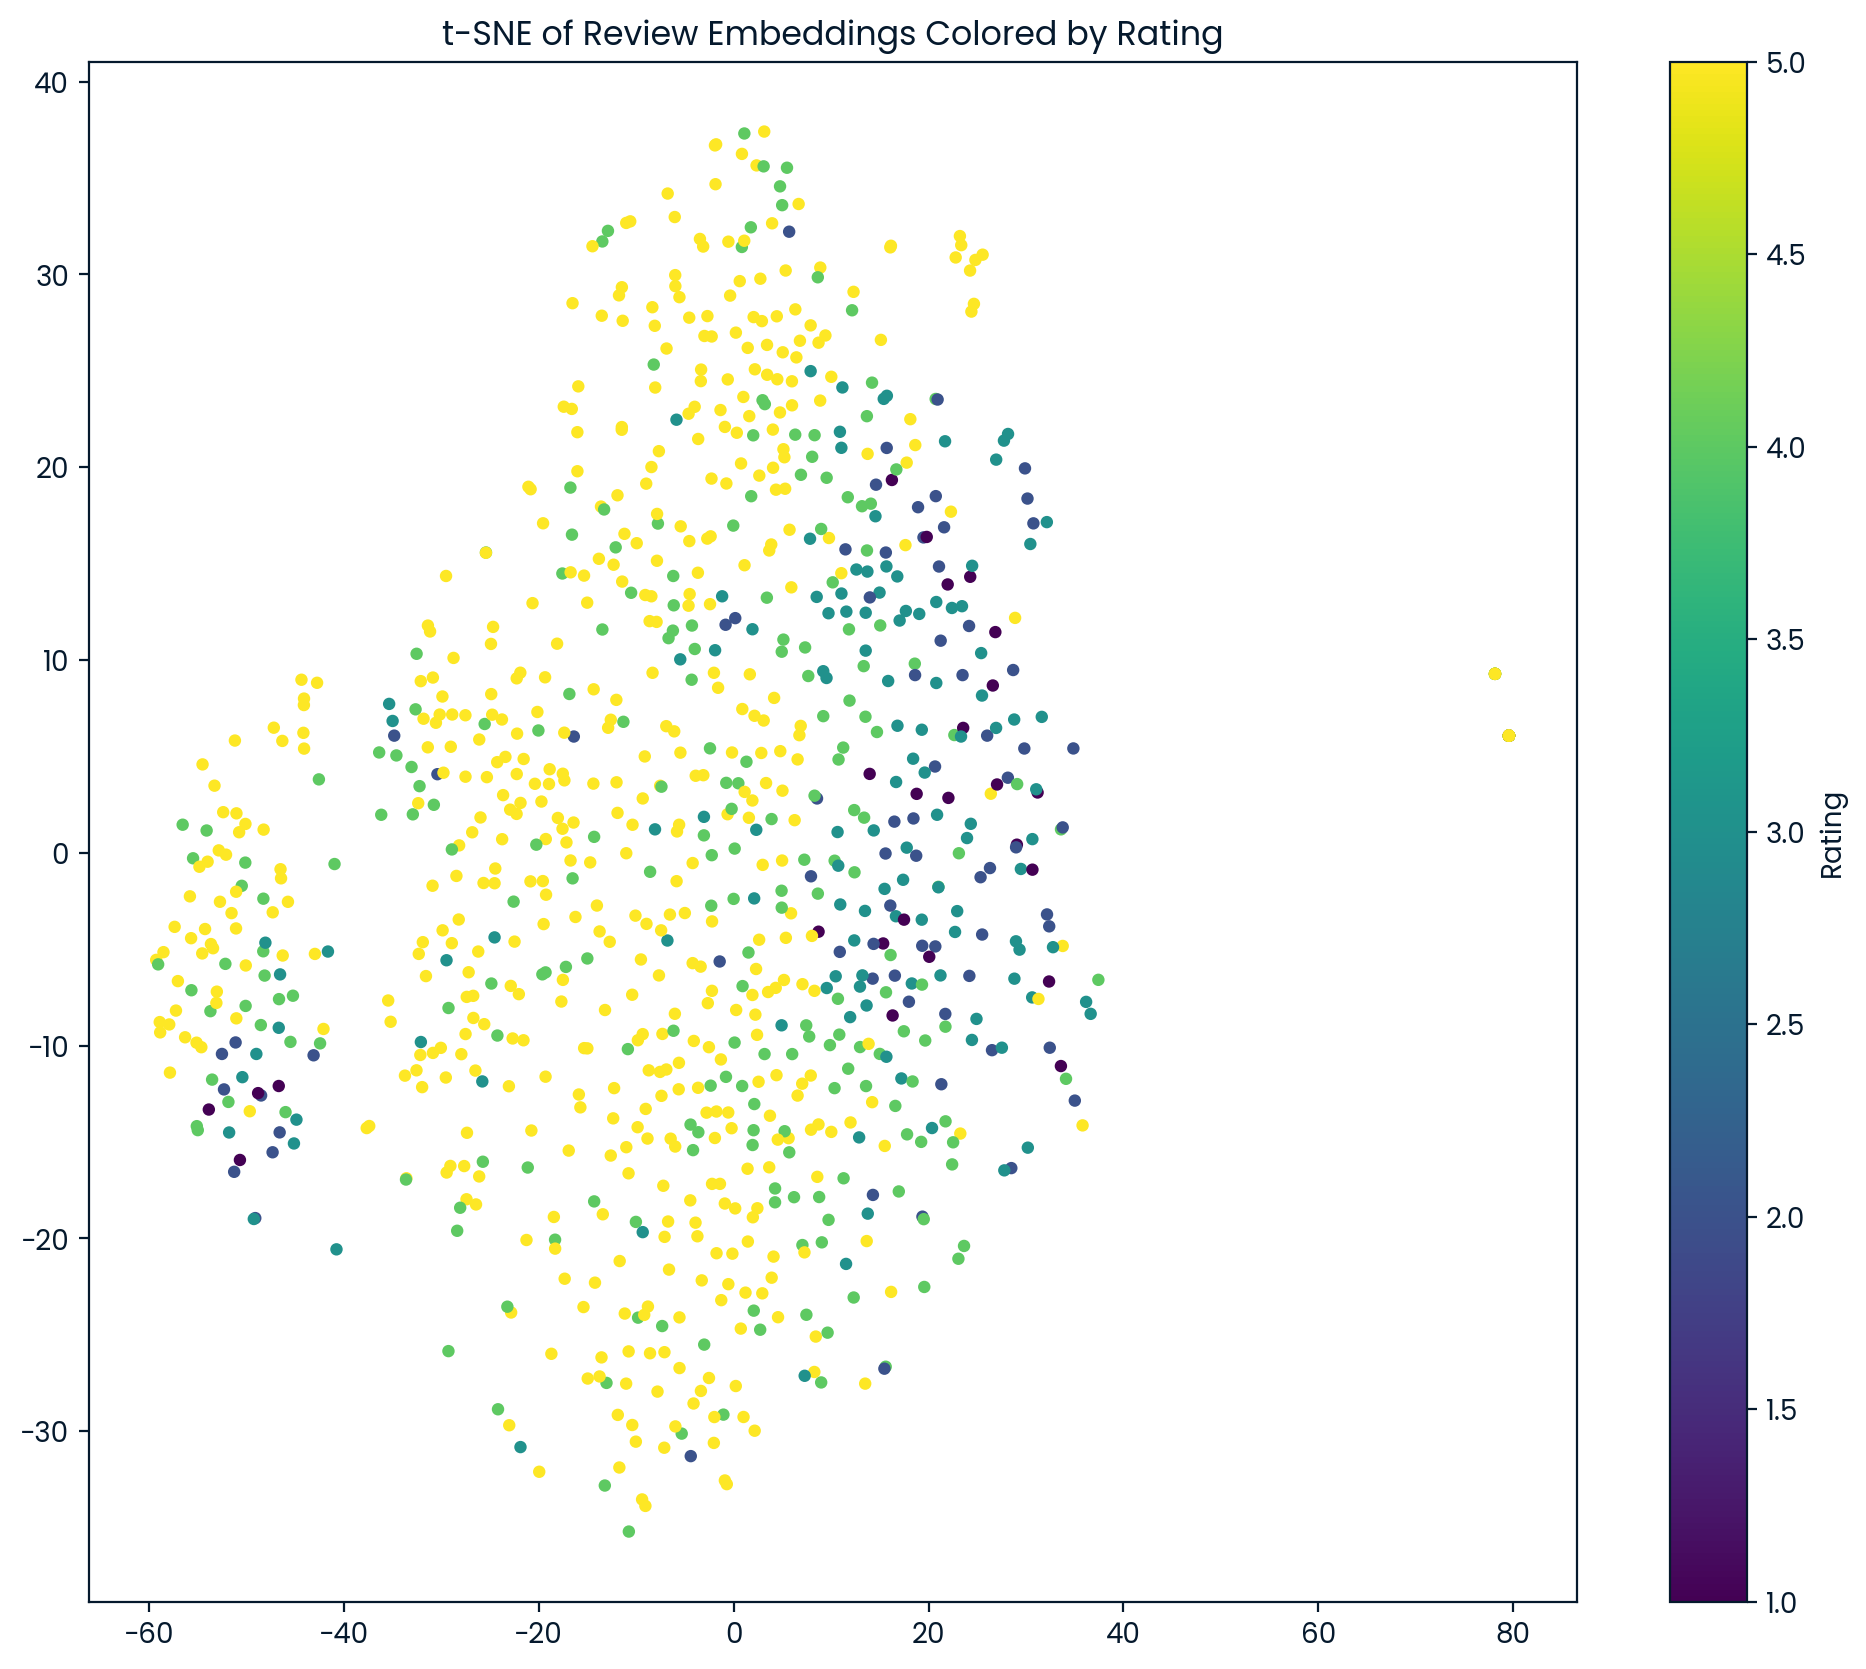

In [9]:
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt

# Use t-SNE to reduce dimension
tsne = TSNE(n_components=2, perplexity=40)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

ratings = reviews["Rating"].values

plt.figure(figsize=(12, 10))
plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=ratings,
    cmap='viridis', 
    s=12
)
plt.colorbar(label="Rating")
plt.title("t-SNE of Review Embeddings Colored by Rating")
plt.show()

## Feedback categorization
- Use your embeddings to identify some reviews that discuss topics such as 'quality', 'fit', 'style', 'comfort', etc.

In [10]:
topics = [{'label': 'Quality', 'description': 'A review about quality of the clothing'},
          {'label': 'Fit', },
          {'label': 'Style', 'description': 'A review about style of the clothing'},
          {'label': 'Comfort', 'description': 'A review about comfort of the clothing'}]

class_descriptions = [topic['label'] for topic in topics]

class_embeddings = create_embeddings(class_descriptions)

In [11]:
# Compare class and review embeddings
from scipy.spatial import distance

def find_closest(query_vector, embeddings):
  distances = []
  for index, embedding in enumerate(embeddings):
    dist = distance.cosine(query_vector, embedding)
    distances.append({"distance": dist, "index": index})
  return min(distances, key=lambda x: x["distance"])

# Show 10 results
for index, review in enumerate(reviews_texts[:10]):
  closest = find_closest(embeddings[index], class_embeddings)
  label = topics[closest['index']]['label']
  print(f'"{review}" -> {label}')

"Absolutely wonderful - silky and sexy and comfortable" -> Comfort
"Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8\".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite." -> Fit
"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c" -> Fit
"I love, love, love this jumpsuit. it\'s fun, flirty, and fabulous! every time i wear it, i get nothing b

## Similarity search function
- Write a function that outputs the closest 3 reviews to a given input review, enabling a more personalized customer service response.
- Apply this function to the first review "Absolutely wonderful - silky and sexy and comfortable", and store the output as a list in the variable most_similar_reviews.

In [12]:
def find_n_closest(query_vector, embeddings, n=3):
  distances = []
  for index, embedding in enumerate(embeddings):
    # Calculate the cosine distance between the query vector and embedding
    dist = distance.cosine(query_vector, embedding)
    # Append the distance and index to distances
    distances.append({"distance": dist, "index": index})
  # Sort distances by the distance key
  distances_sorted = sorted(distances, key=lambda x: x["distance"])
  # Return the first n elements in distances_sorted
  return distances_sorted[0:n]

query_text = reviews_texts[0]
query_vector = create_embeddings(query_text)[0]

hits = find_n_closest(query_vector, embeddings)

most_similar_reviews = []
for hit in hits:
  # Extract the product at each index in hits
  review = reviews_texts[hit['index']]
  most_similar_reviews.append(review)

print(f'Search results for "{query_text}":\n')
print("\n".join(most_similar_reviews))

Search results for "Absolutely wonderful - silky and sexy and comfortable":

Absolutely wonderful - silky and sexy and comfortable
Very comfortable and versatile. got lots of compliments.
This is a very comfortable and sexy sleep dress, the way it drapes. i can see that the type of fabric is not suitable for out and about activities and can catch on snags, etc. very easily. once i relegated it to the nightgown category it became my favorite item to wear and lounge in.


## Similarity Search using Vector Database (ChromaDB)

In [17]:
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

db_client = chromadb.PersistentClient()

collection = db_client.create_collection(
    name="clothing_reviews",
    embedding_function=OpenAIEmbeddingFunction(
        model_name="text-embedding-3-small"
    )
)

In [32]:
# Get ids and documents
import csv

ids = []
documents = []

with open('womens_clothing_e-commerce_reviews.csv') as csvfile:
  reader = csv.DictReader(csvfile)
  for i, row in enumerate(reader):
    ids.append(row['Review ID'])
    text = f"Review Text: {row['Review Text']}"
    documents.append(text)

In [33]:
collection.add(ids=ids, documents=documents)

In [36]:
result = collection.query(
  query_texts=['reviews similar to "Absolutely wonderful - silky and sexy and comfortable"'],
  n_results=3
)
print(f'Search results for "Absolutely wonderful - silky and sexy and comfortable":\n')
print("\n".join(result['documents'][0]))

Search results for "Absolutely wonderful - silky and sexy and comfortable":

Review Text: Absolutely wonderful - silky and sexy and comfortable
Review Text: Very comfortable and versatile. got lots of compliments.
Review Text: This is a very comfortable and sexy sleep dress, the way it drapes. i can see that the type of fabric is not suitable for out and about activities and can catch on snags, etc. very easily. once i relegated it to the nightgown category it became my favorite item to wear and lounge in.
